# Training Analysis: Coverage & Reward/Episode Metrics

This notebook analyzes training results with focus on:
1. **Coverage**: Node coverage during training (visited nodes / total nodes)
2. **Reward/Episode Ratio**: Reward per step and reward per episode trends
3. **Training Progress**: Comprehensive metrics visualization from TensorBoard
4. **Model Performance**: Success rate, hops, latency analysis


## 1. Setup & Configuration


In [21]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import logging
from datetime import datetime
import json
from typing import Dict, List, Tuple, Optional
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [22]:
# Import project modules
from config import Config
from models.database import Database
from agent.dueling_dqn import DuelingDQNAgent
from environment.routing_env import RoutingEnvironment
from environment.state_builder import RoutingStateBuilder
from training.trainer import RoutingTrainer
from training.enhanced_trainer import EnhancedRoutingTrainer

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded


## 2. Load Training Metrics from Checkpoints


In [23]:
def load_training_metrics():
    """Load training metrics from checkpoint files"""
    logger.info("=" * 60)
    logger.info("Loading Training Metrics")
    logger.info("=" * 60)
    
    # Get checkpoint path from config (relative to Backend root)
    checkpoint_path_str = config.get('rl_agent', {}).get('checkpoint_path', './models/checkpoints')
    
    # Convert to absolute path (from Backend root, not notebook directory)
    if not os.path.isabs(checkpoint_path_str):
        # Get Backend root directory (parent of notebooks directory)
        backend_root = Path(os.path.abspath('..'))
        checkpoint_path = backend_root / checkpoint_path_str.lstrip('./')
    else:
        checkpoint_path = Path(checkpoint_path_str)
    
    logger.info(f"Looking for metrics in: {checkpoint_path.absolute()}")
    
    if not checkpoint_path.exists():
        logger.warning(f"Checkpoint directory not found: {checkpoint_path.absolute()}")
        return None
    
    metrics_files = sorted(checkpoint_path.glob('metrics_ep*.json'))
    
    if not metrics_files:
        logger.warning(f"No metrics files found in {checkpoint_path.absolute()}")
        logger.warning("Training may not have been run yet, or checkpoints haven't been saved.")
        return None
    
    logger.info(f"Found {len(metrics_files)} metrics files")
    
    all_metrics = []
    
    for metrics_file in metrics_files:
        try:
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
                all_metrics.append(metrics)
        except Exception as e:
            logger.warning(f"Error loading {metrics_file}: {e}")
    
    if not all_metrics:
        logger.warning("No valid metrics files could be loaded.")
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_metrics)
    
    # Calculate reward per step if not present
    if 'episode_rewards' in df.columns and 'episode_lengths' in df.columns:
        reward_per_step_list = []
        for idx, row in df.iterrows():
            rewards = row.get('episode_rewards', [])
            lengths = row.get('episode_lengths', [])
            if rewards and lengths:
                rps = [r/l if l > 0 else 0 for r, l in zip(rewards, lengths)]
                reward_per_step_list.append(np.mean(rps) if rps else 0)
            else:
                reward_per_step_list.append(0)
        df['mean_reward_per_step'] = reward_per_step_list
    
    logger.info(f"Loaded {len(df)} checkpoint metrics")
    logger.info(f"Episodes range: {df['episode'].min()} - {df['episode'].max()}")
    
    return df

training_metrics_df = load_training_metrics()
if training_metrics_df is not None:
    print("\n📊 Training Metrics Summary:")
    print(f"  Total checkpoints: {len(training_metrics_df)}")
    print(f"  Episodes: {training_metrics_df['episode'].min()} - {training_metrics_df['episode'].max()}")
    print(f"  Best mean reward: {training_metrics_df['best_mean_reward'].max():.2f}")
else:
    print("⚠️ No training metrics found. Run training first.")


INFO:__main__:============================================================
INFO:__main__:Loading Training Metrics
INFO:__main__:============================================================
INFO:__main__:Looking for metrics in: /Users/anhnon/AI-PRACNS/Backend/models/checkpoints
INFO:__main__:Found 20 metrics files
INFO:__main__:Loaded 20 checkpoint metrics
INFO:__main__:Episodes range: 99 - 1999



📊 Training Metrics Summary:
  Total checkpoints: 20
  Episodes: 99 - 1999
  Best mean reward: 16343.95


## 3. Test Coverage & Reward/Episode Metrics


In [24]:
def test_coverage_and_reward_metrics():
    """Test coverage and reward/episode metrics with trained or untrained model"""
    logger.info("=" * 60)
    logger.info("Testing Coverage & Reward/Episode Metrics")
    logger.info("=" * 60)
    
    # Load nodes and terminals
    nodes_collection = db.get_collection('nodes')
    terminals_collection = db.get_collection('terminals')
    
    nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}).limit(100))
    terminals = list(terminals_collection.find({}, {'_id': 0}).limit(20))
    
    if len(nodes) < 5 or len(terminals) < 2:
        logger.error("Not enough nodes or terminals for testing")
        return None
    
    # Try to load checkpoint first to get correct dimensions
    best_model_path_str = config.get('rl_agent', {}).get('best_model_path', './models/best_models')
    # Convert to absolute path
    if not os.path.isabs(best_model_path_str):
        backend_root = Path(os.path.abspath('..'))
        best_model_dir = backend_root / best_model_path_str.lstrip('./')
    else:
        best_model_dir = Path(best_model_path_str)
    best_model_path = best_model_dir / 'best_model.pt'
    
    # Load checkpoint to get state_dim and action_dim
    state_dim = None
    action_dim = None
    model_loaded = False
    
    if best_model_path.exists():
        try:
            checkpoint = torch.load(str(best_model_path), map_location='cpu', weights_only=False)
            if 'state_dim' in checkpoint:
                state_dim = checkpoint['state_dim']
            if 'action_dim' in checkpoint:
                action_dim = checkpoint['action_dim']
            
            # If not in checkpoint, try to infer from state_dict
            if state_dim is None and 'q_network_state_dict' in checkpoint:
                # Infer from input_norm weight shape
                for key in checkpoint['q_network_state_dict'].keys():
                    if 'input_norm.weight' in key:
                        state_dim = checkpoint['q_network_state_dict'][key].shape[0]
                        break
            
            if action_dim is None and 'q_network_state_dict' in checkpoint:
                # Infer from advantage_stream output layer
                for key in checkpoint['q_network_state_dict'].keys():
                    if 'advantage_stream.6.weight' in key:
                        action_dim = checkpoint['q_network_state_dict'][key].shape[0]
                        break
            
            logger.info(f"Loaded dimensions from checkpoint: state_dim={state_dim}, action_dim={action_dim}")
        except Exception as e:
            logger.warning(f"Could not read checkpoint dimensions: {e}")
    
    # If checkpoint dimensions not available, use config
    if state_dim is None or action_dim is None:
        # Create environment to get action_dim
        env_temp = RoutingEnvironment(
            nodes=nodes,
            terminals=terminals,
            config=config,
            max_steps=15
        )
        
        # Initialize state builder to get state_dim
        state_builder_temp = RoutingStateBuilder(config)
        state_dim = state_builder_temp.state_dimension
        action_dim = env_temp.action_space.n
        logger.info(f"Using dimensions from config: state_dim={state_dim}, action_dim={action_dim}")
    
    # Create environment with correct nodes
    env = RoutingEnvironment(
        nodes=nodes,
        terminals=terminals,
        config=config,
        max_steps=15
    )
    
    # Create agent with dimensions from checkpoint (or config if not available)
    agent = DuelingDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        config=config
    )
    
    # Try to load best model
    if best_model_path.exists():
        try:
            agent.load(str(best_model_path))
            agent.eval()
            model_loaded = True
            logger.info(f"✓ Loaded trained model from {best_model_path}")
        except Exception as e:
            logger.warning(f"Could not load model: {e}. Using untrained model.")
            agent.eval()
    else:
        logger.info("No trained model found. Using untrained model for testing.")
        agent.eval()
    
    # Test metrics
    results = []
    num_test_episodes = 50
    
    logger.info(f"Running {num_test_episodes} test episodes...")
    
    all_visited_nodes = set()
    episode_rewards = []
    episode_lengths = []
    episode_success = []
    reward_per_step_list = []
    
    for episode in range(num_test_episodes):
        state, info = env.reset()
        episode_reward = 0.0
        episode_length = 0
        done = False
        
        while not done and episode_length < env.max_steps:
            action = agent.select_action(state, deterministic=True)
            next_state, reward, terminated, truncated, step_info = env.step(action)
            
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1
            state = next_state
        
        # Calculate coverage for this episode
        visited_nodes_episode = env.visited_nodes if hasattr(env, 'visited_nodes') else set()
        all_visited_nodes.update(visited_nodes_episode)
        coverage_episode = len(visited_nodes_episode) / len(nodes) if len(nodes) > 0 else 0.0
        
        # Calculate reward per step
        reward_per_step = episode_reward / episode_length if episode_length > 0 else 0.0
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_success.append(1 if terminated else 0)
        reward_per_step_list.append(reward_per_step)
        
        results.append({
            'episode': episode + 1,
            'reward': episode_reward,
            'length': episode_length,
            'success': terminated,
            'coverage': coverage_episode,
            'reward_per_step': reward_per_step,
            'visited_nodes': len(visited_nodes_episode)
        })
    
    # Calculate overall metrics
    total_coverage = len(all_visited_nodes) / len(nodes) if len(nodes) > 0 else 0.0
    mean_reward = np.mean(episode_rewards)
    mean_length = np.mean(episode_lengths)
    mean_reward_per_step = np.mean(reward_per_step_list)
    success_rate = np.mean(episode_success)
    mean_coverage = np.mean([r['coverage'] for r in results])
    
    logger.info(f"\nTest Results:")
    logger.info(f"  Total coverage (all episodes): {total_coverage:.2%}")
    logger.info(f"  Mean episode coverage: {mean_coverage:.2%}")
    logger.info(f"  Mean reward: {mean_reward:.2f}")
    logger.info(f"  Mean length: {mean_length:.1f}")
    logger.info(f"  Mean reward per step: {mean_reward_per_step:.2f}")
    logger.info(f"  Success rate: {success_rate:.2%}")
    logger.info(f"  Model loaded: {model_loaded}")
    
    df = pd.DataFrame(results)
    
    summary = {
        'total_coverage': total_coverage,
        'mean_episode_coverage': mean_coverage,
        'mean_reward': mean_reward,
        'mean_length': mean_length,
        'mean_reward_per_step': mean_reward_per_step,
        'success_rate': success_rate,
        'model_loaded': model_loaded,
        'num_episodes': num_test_episodes,
        'total_nodes': len(nodes),
        'visited_nodes_total': len(all_visited_nodes)
    }
    
    return df, summary

coverage_df, summary_stats = test_coverage_and_reward_metrics()
if coverage_df is not None:
    print("\n📊 Coverage & Reward Metrics:")
    print(f"  Total Coverage: {summary_stats['total_coverage']:.2%}")
    print(f"  Mean Episode Coverage: {summary_stats['mean_episode_coverage']:.2%}")
    print(f"  Mean Reward/Step: {summary_stats['mean_reward_per_step']:.2f}")
    print(f"  Success Rate: {summary_stats['success_rate']:.2%}")


INFO:__main__:============================================================
INFO:__main__:Testing Coverage & Reward/Episode Metrics
INFO:__main__:============================================================
INFO:__main__:Loaded dimensions from checkpoint: state_dim=974, action_dim=53
INFO:environment.routing_env:Dynamic max_steps: 26 (operational_nodes=53, base=15, estimated_hops=26)
INFO:agent.dueling_dqn:Initializing DuelingDQN Agent on device: cpu
INFO:agent.dueling_dqn:DuelingDQN Agent initialized: state_dim=974, action_dim=53
INFO:agent.dueling_dqn:Agent loaded from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt
INFO:__main__:✓ Loaded trained model from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt
INFO:__main__:Running 50 test episodes...
INFO:__main__:
Test Results:
INFO:__main__:  Total coverage (all episodes): 50.94%
INFO:__main__:  Mean episode coverage: 5.36%
INFO:__main__:  Mean reward: -8523.30
INFO:__main__:  Mean length: 7.5
INFO:__mai


📊 Coverage & Reward Metrics:
  Total Coverage: 50.94%
  Mean Episode Coverage: 5.36%
  Mean Reward/Step: 381.89
  Success Rate: 60.00%


## 4. Visualize Coverage Metrics


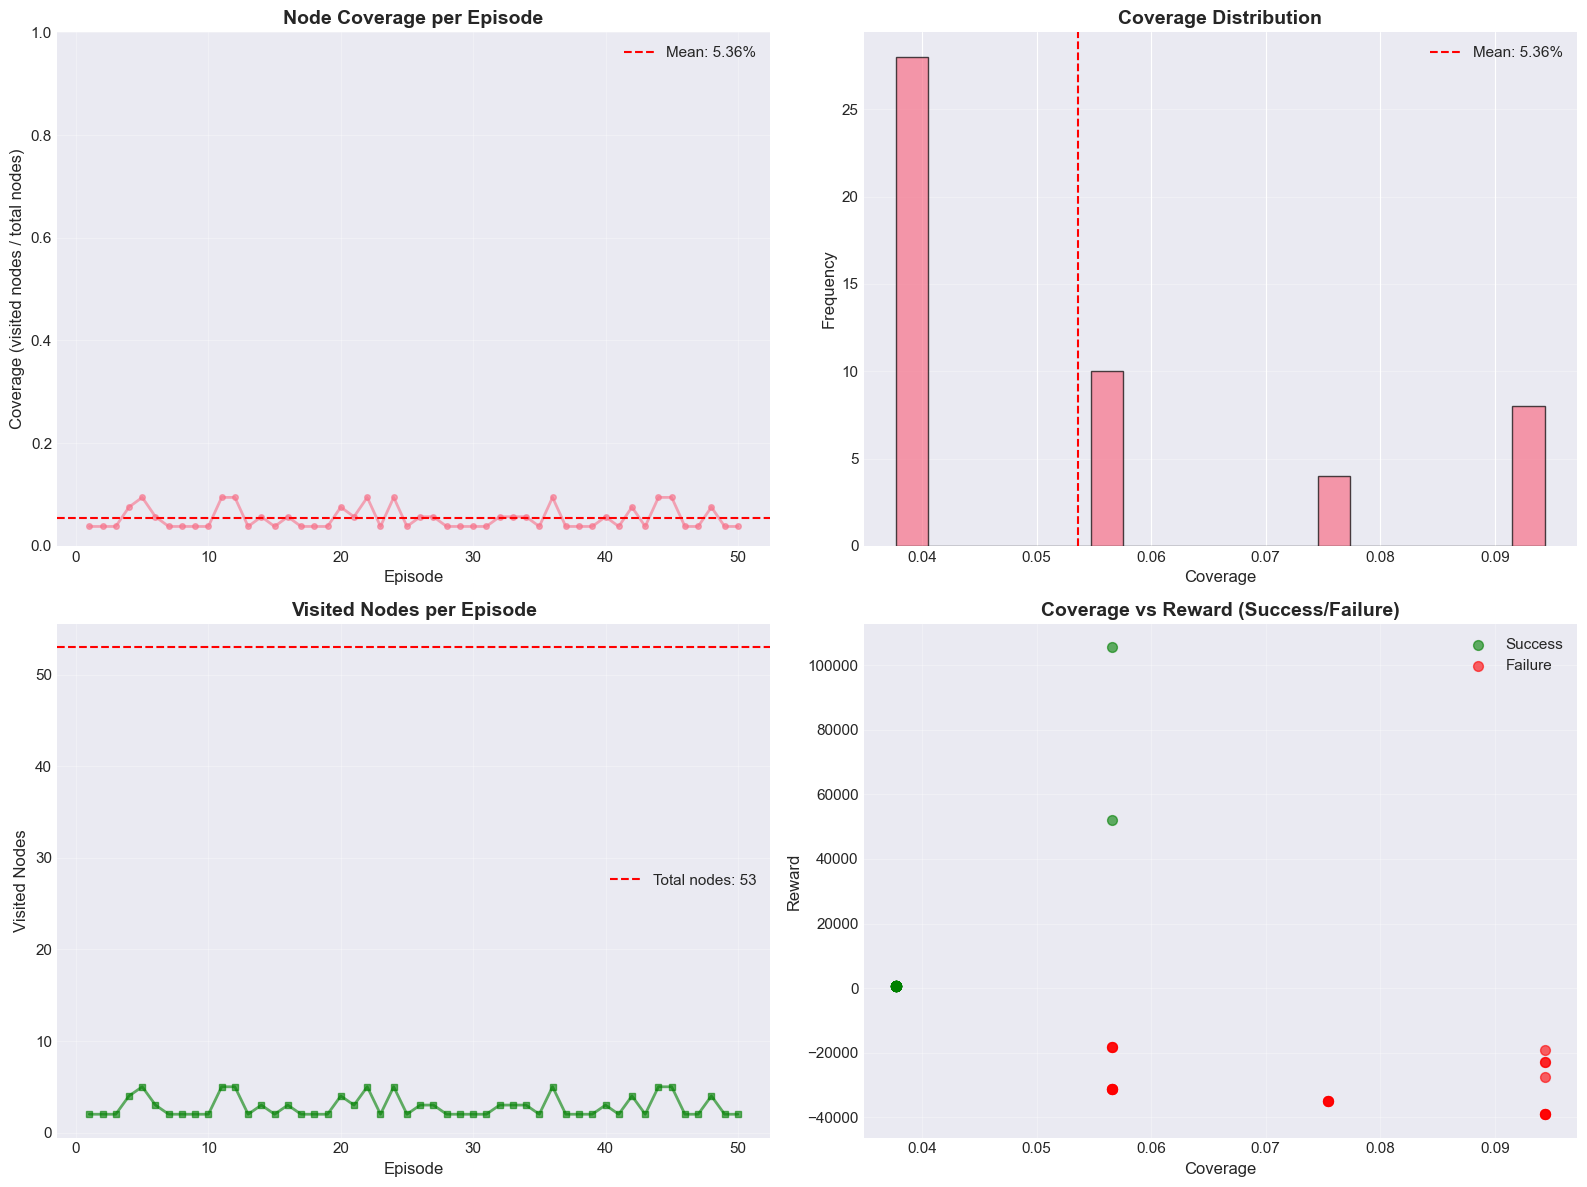


✓ Coverage visualization complete
  Total nodes: 53
  Visited nodes (all episodes): 27
  Total coverage: 50.94%


In [25]:
# Visualize coverage metrics
if coverage_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Coverage over episodes
    ax1 = axes[0, 0]
    ax1.plot(coverage_df['episode'], coverage_df['coverage'], 'o-', alpha=0.6, linewidth=2, markersize=4)
    ax1.axhline(y=summary_stats['mean_episode_coverage'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_episode_coverage"]:.2%}')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Coverage (visited nodes / total nodes)', fontsize=12)
    ax1.set_title('Node Coverage per Episode', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # 2. Coverage distribution
    ax2 = axes[0, 1]
    ax2.hist(coverage_df['coverage'], bins=20, edgecolor='black', alpha=0.7)
    ax2.axvline(x=summary_stats['mean_episode_coverage'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_episode_coverage"]:.2%}')
    ax2.set_xlabel('Coverage', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Coverage Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Visited nodes per episode
    ax3 = axes[1, 0]
    ax3.plot(coverage_df['episode'], coverage_df['visited_nodes'], 's-', alpha=0.6, 
             linewidth=2, markersize=4, color='green')
    ax3.axhline(y=summary_stats['total_nodes'], color='r', linestyle='--', 
                label=f'Total nodes: {summary_stats["total_nodes"]}')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Visited Nodes', fontsize=12)
    ax3.set_title('Visited Nodes per Episode', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Coverage vs Success
    ax4 = axes[1, 1]
    success_data = coverage_df[coverage_df['success'] == 1]
    failure_data = coverage_df[coverage_df['success'] == 0]
    
    if len(success_data) > 0:
        ax4.scatter(success_data['coverage'], success_data['reward'], 
                   alpha=0.6, label='Success', s=50, color='green')
    if len(failure_data) > 0:
        ax4.scatter(failure_data['coverage'], failure_data['reward'], 
                   alpha=0.6, label='Failure', s=50, color='red')
    
    ax4.set_xlabel('Coverage', fontsize=12)
    ax4.set_ylabel('Reward', fontsize=12)
    ax4.set_title('Coverage vs Reward (Success/Failure)', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Coverage visualization complete")
    print(f"  Total nodes: {summary_stats['total_nodes']}")
    print(f"  Visited nodes (all episodes): {summary_stats['visited_nodes_total']}")
    print(f"  Total coverage: {summary_stats['total_coverage']:.2%}")


## 5. Visualize Reward/Episode Metrics


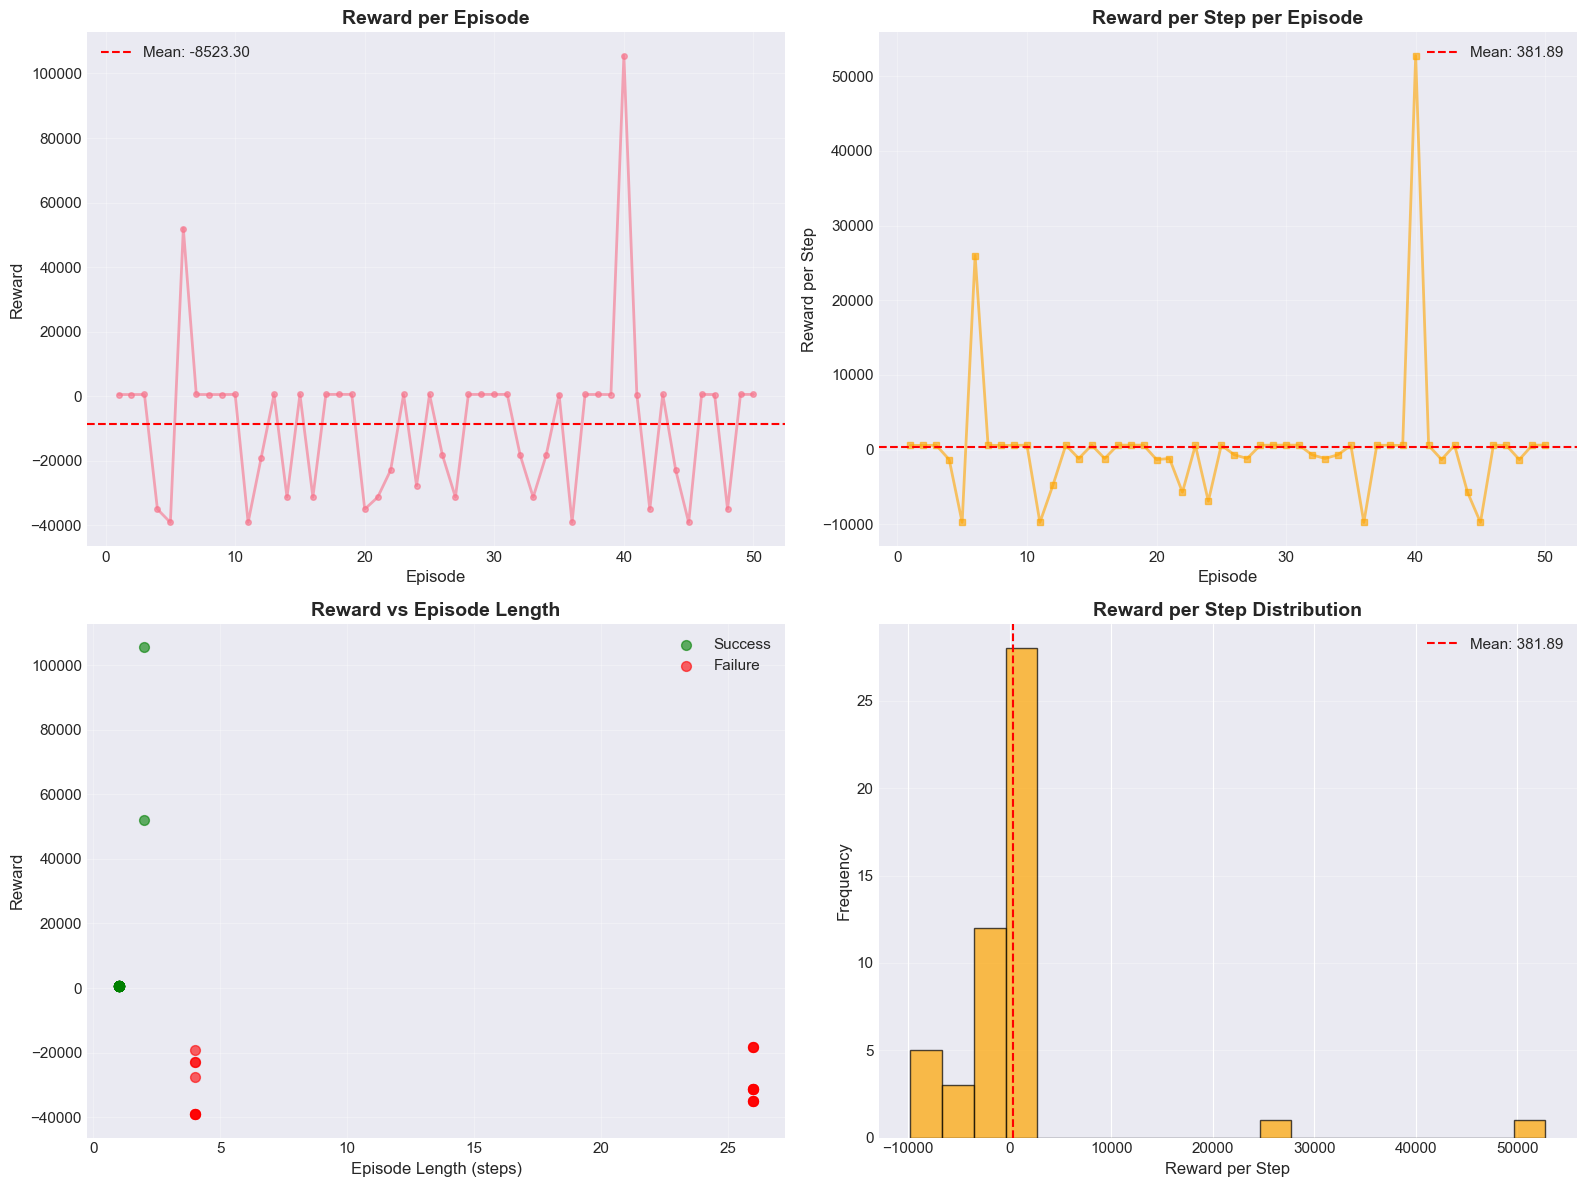


✓ Reward/Episode visualization complete
  Mean reward: -8523.30
  Mean reward per step: 381.89
  Mean episode length: 7.5


In [26]:
# Visualize reward/episode metrics
if coverage_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Reward per episode
    ax1 = axes[0, 0]
    ax1.plot(coverage_df['episode'], coverage_df['reward'], 'o-', alpha=0.6, linewidth=2, markersize=4)
    ax1.axhline(y=summary_stats['mean_reward'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_reward"]:.2f}')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Reward', fontsize=12)
    ax1.set_title('Reward per Episode', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Reward per step
    ax2 = axes[0, 1]
    ax2.plot(coverage_df['episode'], coverage_df['reward_per_step'], 's-', alpha=0.6, 
             linewidth=2, markersize=4, color='orange')
    ax2.axhline(y=summary_stats['mean_reward_per_step'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_reward_per_step"]:.2f}')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Reward per Step', fontsize=12)
    ax2.set_title('Reward per Step per Episode', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Reward vs Episode Length
    ax3 = axes[1, 0]
    success_mask = coverage_df['success'] == 1
    ax3.scatter(coverage_df.loc[success_mask, 'length'], coverage_df.loc[success_mask, 'reward'], 
               alpha=0.6, label='Success', s=50, color='green')
    ax3.scatter(coverage_df.loc[~success_mask, 'length'], coverage_df.loc[~success_mask, 'reward'], 
               alpha=0.6, label='Failure', s=50, color='red')
    ax3.set_xlabel('Episode Length (steps)', fontsize=12)
    ax3.set_ylabel('Reward', fontsize=12)
    ax3.set_title('Reward vs Episode Length', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Reward per Step Distribution
    ax4 = axes[1, 1]
    ax4.hist(coverage_df['reward_per_step'], bins=20, edgecolor='black', alpha=0.7, color='orange')
    ax4.axvline(x=summary_stats['mean_reward_per_step'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_reward_per_step"]:.2f}')
    ax4.set_xlabel('Reward per Step', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Reward per Step Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Reward/Episode visualization complete")
    print(f"  Mean reward: {summary_stats['mean_reward']:.2f}")
    print(f"  Mean reward per step: {summary_stats['mean_reward_per_step']:.2f}")
    print(f"  Mean episode length: {summary_stats['mean_length']:.1f}")


## 6. Comprehensive Metrics Dashboard


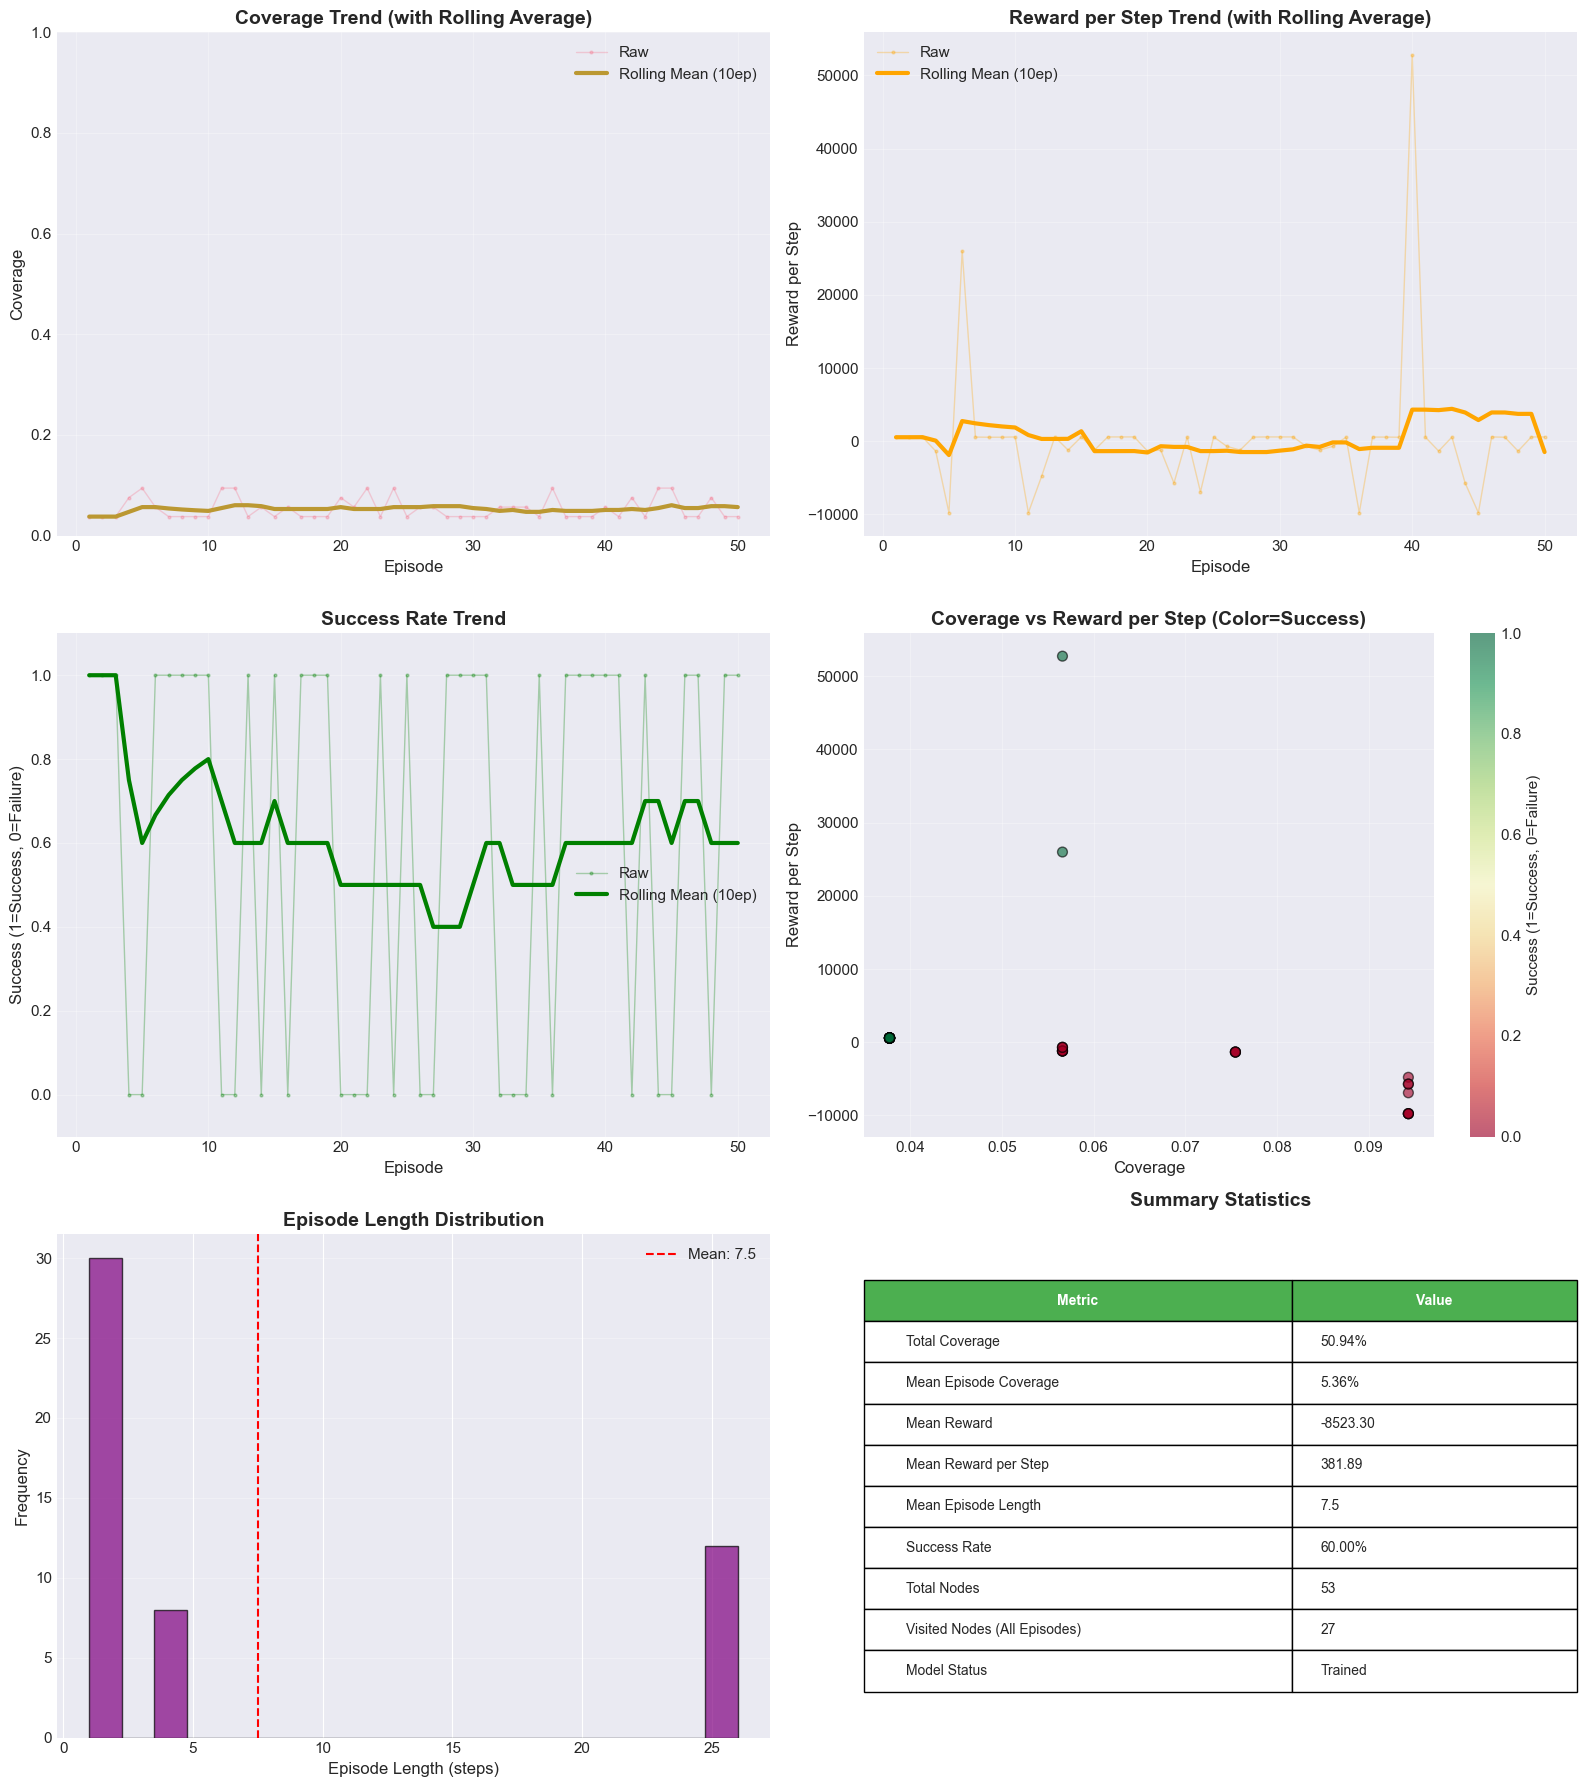


✓ Comprehensive metrics dashboard complete


In [27]:
# Create comprehensive metrics dashboard
if coverage_df is not None:
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Coverage Trend (rolling average)
    ax1 = axes[0, 0]
    window = 10
    coverage_rolling = coverage_df['coverage'].rolling(window=window, min_periods=1).mean()
    ax1.plot(coverage_df['episode'], coverage_df['coverage'], 'o-', alpha=0.3, linewidth=1, markersize=2, label='Raw')
    ax1.plot(coverage_df['episode'], coverage_rolling, '-', linewidth=3, label=f'Rolling Mean ({window}ep)')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Coverage', fontsize=12)
    ax1.set_title('Coverage Trend (with Rolling Average)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # 2. Reward per Step Trend (rolling average)
    ax2 = axes[0, 1]
    reward_per_step_rolling = coverage_df['reward_per_step'].rolling(window=window, min_periods=1).mean()
    ax2.plot(coverage_df['episode'], coverage_df['reward_per_step'], 'o-', alpha=0.3, linewidth=1, markersize=2, label='Raw', color='orange')
    ax2.plot(coverage_df['episode'], reward_per_step_rolling, '-', linewidth=3, label=f'Rolling Mean ({window}ep)', color='orange')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Reward per Step', fontsize=12)
    ax2.set_title('Reward per Step Trend (with Rolling Average)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Success Rate Trend
    ax3 = axes[1, 0]
    success_rolling = coverage_df['success'].rolling(window=window, min_periods=1).mean()
    ax3.plot(coverage_df['episode'], coverage_df['success'], 'o-', alpha=0.3, linewidth=1, markersize=2, label='Raw', color='green')
    ax3.plot(coverage_df['episode'], success_rolling, '-', linewidth=3, label=f'Rolling Mean ({window}ep)', color='green')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Success (1=Success, 0=Failure)', fontsize=12)
    ax3.set_title('Success Rate Trend', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([-0.1, 1.1])
    
    # 4. Coverage vs Reward per Step
    ax4 = axes[1, 1]
    scatter = ax4.scatter(coverage_df['coverage'], coverage_df['reward_per_step'], 
                         c=coverage_df['success'], cmap='RdYlGn', alpha=0.6, s=50, edgecolors='black')
    ax4.set_xlabel('Coverage', fontsize=12)
    ax4.set_ylabel('Reward per Step', fontsize=12)
    ax4.set_title('Coverage vs Reward per Step (Color=Success)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Success (1=Success, 0=Failure)')
    
    # 5. Episode Length Distribution
    ax5 = axes[2, 0]
    ax5.hist(coverage_df['length'], bins=20, edgecolor='black', alpha=0.7, color='purple')
    ax5.axvline(x=summary_stats['mean_length'], color='r', linestyle='--', 
                label=f'Mean: {summary_stats["mean_length"]:.1f}')
    ax5.set_xlabel('Episode Length (steps)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title('Episode Length Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Summary Statistics Table
    ax6 = axes[2, 1]
    ax6.axis('off')
    
    summary_data = {
        'Metric': [
            'Total Coverage',
            'Mean Episode Coverage',
            'Mean Reward',
            'Mean Reward per Step',
            'Mean Episode Length',
            'Success Rate',
            'Total Nodes',
            'Visited Nodes (All Episodes)',
            'Model Status'
        ],
        'Value': [
            f"{summary_stats['total_coverage']:.2%}",
            f"{summary_stats['mean_episode_coverage']:.2%}",
            f"{summary_stats['mean_reward']:.2f}",
            f"{summary_stats['mean_reward_per_step']:.2f}",
            f"{summary_stats['mean_length']:.1f}",
            f"{summary_stats['success_rate']:.2%}",
            f"{summary_stats['total_nodes']}",
            f"{summary_stats['visited_nodes_total']}",
            'Trained' if summary_stats['model_loaded'] else 'Untrained'
        ]
    }
    
    summary_table = pd.DataFrame(summary_data)
    table = ax6.table(cellText=summary_table.values, colLabels=summary_table.columns,
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # Style table
    for i in range(len(summary_table.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Comprehensive metrics dashboard complete")


## 7. Load TensorBoard Data (if available)


In [28]:
def load_tensorboard_data():
    """Load TensorBoard event files if available"""
    try:
        from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
        
        # Get tensorboard directory from config (relative to Backend root)
        tensorboard_log_dir_str = config.get('rl_agent', {}).get('tensorboard_log_dir', './logs/tensorboard')
        
        # Convert to absolute path (from Backend root, not notebook directory)
        if not os.path.isabs(tensorboard_log_dir_str):
            # Get Backend root directory (parent of notebooks directory)
            backend_root = Path(os.path.abspath('..'))
            tensorboard_dir = backend_root / tensorboard_log_dir_str.lstrip('./')
        else:
            tensorboard_dir = Path(tensorboard_log_dir_str)
        
        logger.info(f"Looking for TensorBoard data in: {tensorboard_dir.absolute()}")
        
        if not tensorboard_dir.exists():
            logger.warning(f"TensorBoard directory not found: {tensorboard_dir.absolute()}")
            # Try alternative: check if files are directly in the directory
            parent_dir = tensorboard_dir.parent
            if parent_dir.exists():
                event_files = list(parent_dir.glob('**/events.out.tfevents.*'))
                if event_files:
                    logger.info(f"Found event files in parent directory: {len(event_files)} files")
                    # Use parent directory
                    tensorboard_dir = parent_dir
        
        if not tensorboard_dir.exists():
            logger.warning(f"TensorBoard directory not found: {tensorboard_dir.absolute()}")
            return None
        
        # Check if there are event files directly in the directory
        event_files = list(tensorboard_dir.glob('events.out.tfevents.*'))
        if event_files:
            # Files are directly in the directory, use the directory itself
            logger.info(f"Found {len(event_files)} event files directly in directory")
            ea = EventAccumulator(str(tensorboard_dir))
        else:
            # Find latest run subdirectory
            runs = sorted([d for d in tensorboard_dir.iterdir() if d.is_dir()], 
                         key=lambda x: x.stat().st_mtime, reverse=True)
            if not runs:
                logger.warning("No TensorBoard runs found")
                return None
            latest_run = runs[0]
            logger.info(f"Loading TensorBoard data from: {latest_run}")
            ea = EventAccumulator(str(latest_run))
        
        ea.Reload()
        
        # Extract scalars
        scalar_tags = ea.Tags().get('scalars', [])
        
        if not scalar_tags:
            logger.warning("No scalar tags found in TensorBoard data")
            return None
        
        tensorboard_data = {}
        for tag in scalar_tags:
            try:
                scalar_events = ea.Scalars(tag)
                tensorboard_data[tag] = {
                    'steps': [e.step for e in scalar_events],
                    'values': [e.value for e in scalar_events],
                    'wall_times': [e.wall_time for e in scalar_events]
                }
            except Exception as e:
                logger.warning(f"Error loading scalar {tag}: {e}")
                continue
        
        logger.info(f"Loaded {len(tensorboard_data)} TensorBoard metrics")
        logger.info(f"Sample metrics: {list(tensorboard_data.keys())[:5]}")
        return tensorboard_data
        
    except ImportError:
        logger.warning("TensorBoard not available. Install with: pip install tensorboard")
        return None
    except Exception as e:
        logger.warning(f"Error loading TensorBoard data: {e}", exc_info=True)
        return None

tensorboard_data = load_tensorboard_data()
if tensorboard_data:
    print(f"\n✓ TensorBoard data loaded")
    print(f"  Available metrics: {len(tensorboard_data)}")
    print(f"  Metrics: {list(tensorboard_data.keys())[:10]}...")
else:
    print("⚠️ TensorBoard data not available. Run training to generate data.")


INFO:__main__:Looking for TensorBoard data in: /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard
INFO:__main__:Found 11 event files directly in directory
INFO:tensorboard:Directory watcher advancing from /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764665504.Mac-Pro-M2-s-Anhnon.local.34556.0 to /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764703694.192.168.1.102.non-exists.ptr.local.49183.0
INFO:tensorboard:Directory watcher advancing from /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764703694.192.168.1.102.non-exists.ptr.local.49183.0 to /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764703852.192.168.1.102.non-exists.ptr.local.54006.0
INFO:tensorboard:Directory watcher advancing from /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764703852.192.168.1.102.non-exists.ptr.local.54006.0 to /Users/anhnon/AI-PRACNS/Backend/logs/tensorboard/events.out.tfevents.1764706169.19


✓ TensorBoard data loaded
  Available metrics: 30
  Metrics: ['train/reward', 'train/mean_reward', 'train/loss', 'curriculum/level', 'curriculum/difficulty', 'imitation/expert_ratio', 'eval/mean_reward', 'eval/success_rate', '1_Training/Reward', '1_Training/Mean_Reward_10ep']...


## 8. Visualize TensorBoard Metrics (if available)


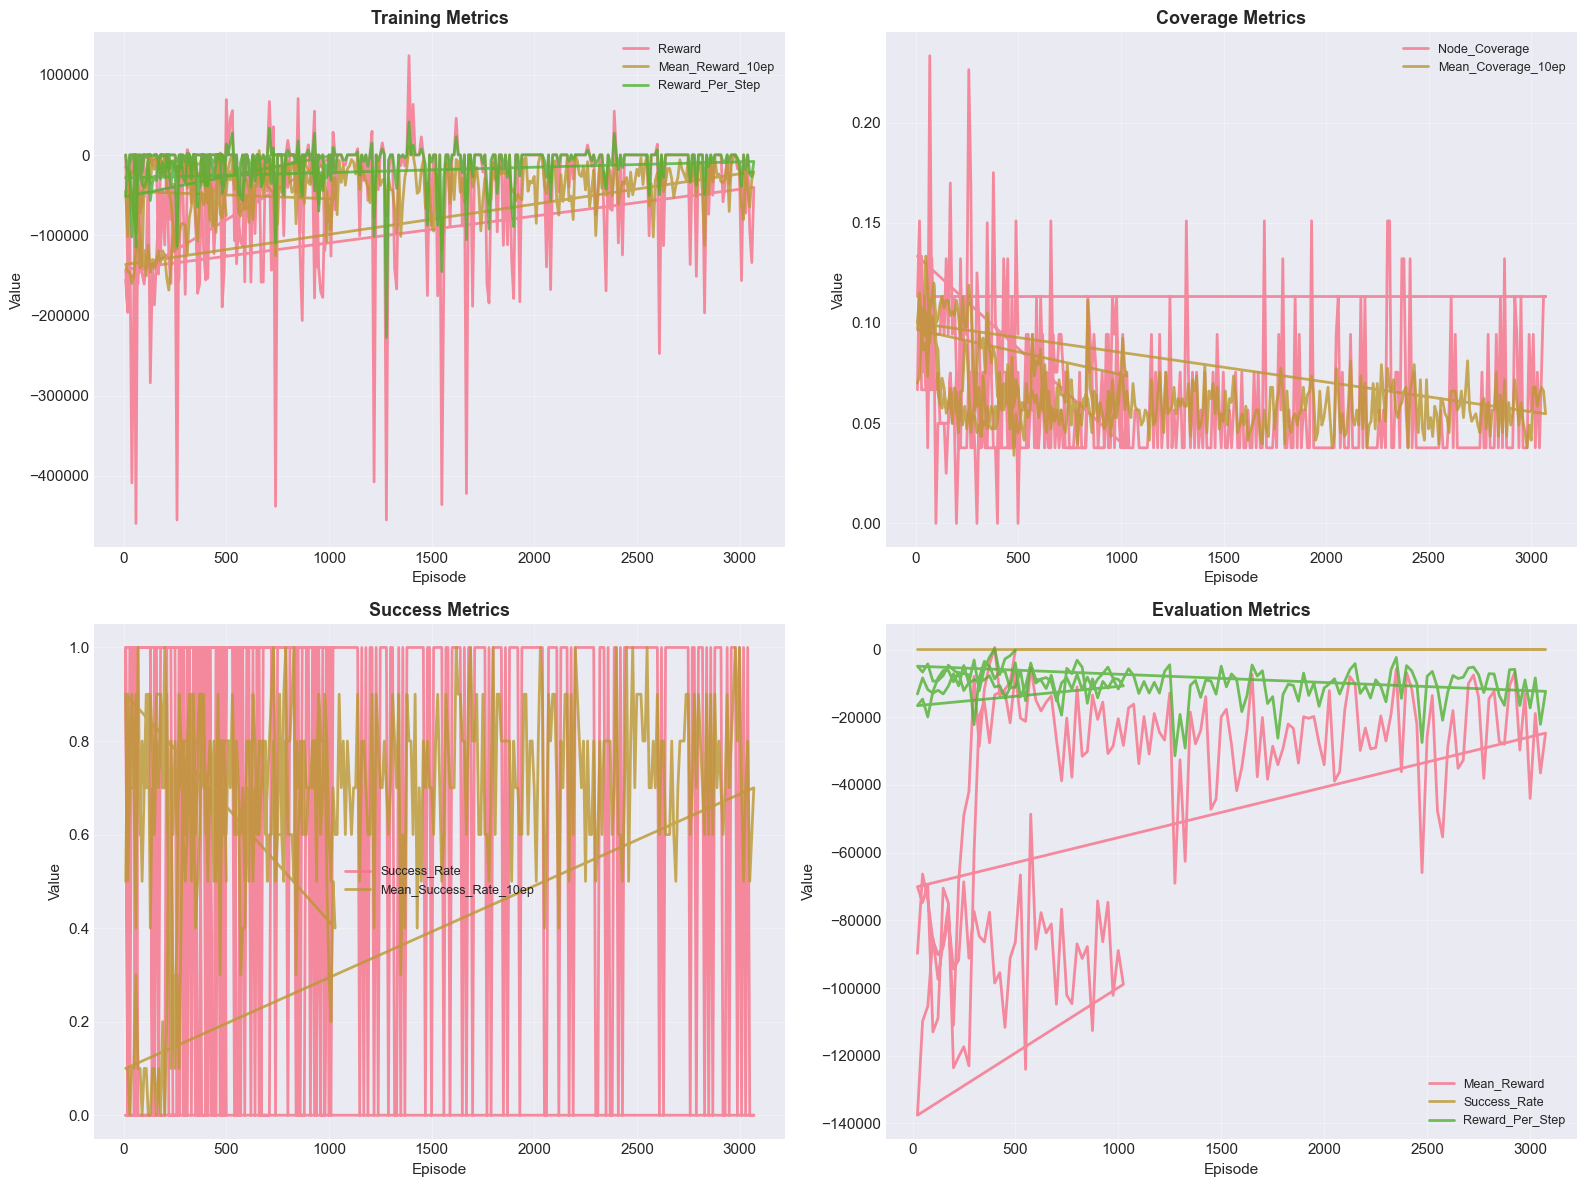


✓ TensorBoard metrics visualization complete

💡 To view full TensorBoard dashboard, run:
   tensorboard --logdir=/Users/anhnon/AI-PRACNS/Backend/logs/tensorboard

   Or from Backend directory:
   cd .. && tensorboard --logdir=logs/tensorboard


In [29]:
# Visualize TensorBoard metrics if available
if tensorboard_data:
    # Filter key metrics
    key_metrics = {
        'Training': ['1_Training/Reward', '1_Training/Mean_Reward_10ep', '1_Training/Reward_Per_Step'],
        'Coverage': ['2_Coverage/Node_Coverage', '2_Coverage/Mean_Coverage_10ep'],
        'Success': ['3_Success/Success_Rate', '3_Success/Mean_Success_Rate_10ep'],
        'Evaluation': ['6_Evaluation/Mean_Reward', '6_Evaluation/Success_Rate', '6_Evaluation/Reward_Per_Step']
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    for category, metrics in key_metrics.items():
        if plot_idx >= 4:
            break
            
        ax = axes[plot_idx]
        
        for metric in metrics:
            if metric in tensorboard_data:
                data = tensorboard_data[metric]
                ax.plot(data['steps'], data['values'], label=metric.split('/')[-1], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Episode', fontsize=11)
        ax.set_ylabel('Value', fontsize=11)
        ax.set_title(f'{category} Metrics', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ TensorBoard metrics visualization complete")
    print(f"\n💡 To view full TensorBoard dashboard, run:")
    # Get absolute path for TensorBoard command
    tensorboard_log_dir_str = config.get('rl_agent', {}).get('tensorboard_log_dir', './logs/tensorboard')
    if not os.path.isabs(tensorboard_log_dir_str):
        backend_root = Path(os.path.abspath('..'))
        tensorboard_abs_path = backend_root / tensorboard_log_dir_str.lstrip('./')
    else:
        tensorboard_abs_path = Path(tensorboard_log_dir_str)
    print(f"   tensorboard --logdir={tensorboard_abs_path.absolute()}")
    print(f"\n   Or from Backend directory:")
    print(f"   cd .. && tensorboard --logdir=logs/tensorboard")
else:
    print("⚠️ TensorBoard data not available for visualization")


## 9. Summary & Recommendations


In [30]:
# Generate final summary
print("=" * 60)
print("TRAINING ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nTest Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if summary_stats:
    print(f"\n📊 Coverage Metrics:")
    print(f"  Total Coverage: {summary_stats['total_coverage']:.2%}")
    print(f"  Mean Episode Coverage: {summary_stats['mean_episode_coverage']:.2%}")
    print(f"  Visited Nodes: {summary_stats['visited_nodes_total']}/{summary_stats['total_nodes']}")
    
    print(f"\n📈 Reward Metrics:")
    print(f"  Mean Reward: {summary_stats['mean_reward']:.2f}")
    print(f"  Mean Reward per Step: {summary_stats['mean_reward_per_step']:.2f}")
    print(f"  Mean Episode Length: {summary_stats['mean_length']:.1f}")
    
    print(f"\n✅ Success Metrics:")
    print(f"  Success Rate: {summary_stats['success_rate']:.2%}")
    
    print(f"\n🤖 Model Status:")
    print(f"  Model Loaded: {summary_stats['model_loaded']}")
    print(f"  Test Episodes: {summary_stats['num_episodes']}")
    
    # Recommendations
    print(f"\n💡 Recommendations:")
    if not summary_stats['model_loaded']:
        print("  ⚠️ No trained model found. Run training first:")
        print("     python -m training.train")
    
    if summary_stats['success_rate'] < 0.5:
        print("  ⚠️ Success rate is low. Consider:")
        print("     - Training for more episodes")
        print("     - Adjusting reward function")
        print("     - Using enhanced trainer with curriculum learning")
    
    if summary_stats['total_coverage'] < 0.5:
        print("  ⚠️ Coverage is low. Agent may be exploring insufficiently.")
        print("     - Check epsilon decay rate")
        print("     - Consider increasing exploration")
    
    if summary_stats['mean_reward_per_step'] < 0:
        print("  ⚠️ Negative reward per step. Agent is not learning effectively.")
        print("     - Review reward function")
        print("     - Check training hyperparameters")

if training_metrics_df is not None:
    print(f"\n📁 Training History:")
    print(f"  Checkpoints loaded: {len(training_metrics_df)}")
    print(f"  Episode range: {training_metrics_df['episode'].min()} - {training_metrics_df['episode'].max()}")
    print(f"  Best reward: {training_metrics_df['best_mean_reward'].max():.2f}")

print("\n" + "=" * 60)
print("✅ Analysis Complete")
print("=" * 60)


TRAINING ANALYSIS SUMMARY

Test Date: 2025-12-20 21:45:24

📊 Coverage Metrics:
  Total Coverage: 50.94%
  Mean Episode Coverage: 5.36%
  Visited Nodes: 27/53

📈 Reward Metrics:
  Mean Reward: -8523.30
  Mean Reward per Step: 381.89
  Mean Episode Length: 7.5

✅ Success Metrics:
  Success Rate: 60.00%

🤖 Model Status:
  Model Loaded: True
  Test Episodes: 50

💡 Recommendations:

📁 Training History:
  Checkpoints loaded: 20
  Episode range: 99 - 1999
  Best reward: 16343.95

✅ Analysis Complete
